In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Merge, Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
import nltk

Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.


In [3]:
## needed variables
'''
1.  encoding_train 
2.  encoding_val
3.  encoding_test
4.  VQG_training_dataset.txt
5.  unique
6.  max_len
7.  samples_per_epoch
8.  word2idx, idx2word
9.  caps
10. max_len


'''


'\n1.  encoding_train \n2.  encoding_val\n3.  encoding_test\n4.  VQG_training_dataset.txt\n5.  unique\n6.  max_len\n7.  samples_per_epoch\n8.  word2idx, idx2word\n9.  caps\n10. max_len\n\n\n'

In [4]:
created_files_dir ='vqg_created_files/'

In [5]:
with open(created_files_dir + "word2idx.pickle","rb")  as fh:
    word2idx= pickle.load(fh)

In [6]:
with open(created_files_dir + "idx2word.pickle","rb")  as fh:
    idx2word= pickle.load(fh)

In [7]:
with open(created_files_dir + "encoded_images_inceptionV3.p","rb")  as fh:
    encoding_train= pickle.load(fh)

In [8]:
with open(created_files_dir + "encoded_images_test_inceptionV3.p","rb")  as fh:
    encoding_test= pickle.load(fh)

In [9]:
with open(created_files_dir + "encoded_images_val_inceptionV3.p","rb")  as fh:
    encoding_val= pickle.load(fh)

In [10]:
unique = pickle.load(open(created_files_dir+'unique.p', 'rb'))

In [11]:
max_len = pickle.load(open(created_files_dir+'max_len.pickle', 'rb'))

In [12]:
caps = pickle.load(open(created_files_dir+'caps.pickle', 'rb'))

In [13]:
images = 'VQg_Dataset/VQG_Dataset/'

In [14]:
# samples_per_epoch = pickle.load(open(created_files_dir+'samples_per_epoch.pickle', 'rb'))
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [15]:
vocab_size = len(unique)

## Generator 

We will use the encoding of an image and use a start word to predict the next word.
After that, we will again use the same image and use the predicted word 
to predict the next word.
So, the image will be used at every iteration for the entire caption. 
This is how we will generate the caption for an image. Hence, we need to create 
a custom generator for that.

The CS231n lecture by Andrej Karpathy explains this concept very clearly and beautifully.
Link for the lecture:- https://youtu.be/cO0a0QYmFm8?t=32m25s

In [16]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv(created_files_dir+'VQG_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

## Let's create the model

In [17]:
embedding_size = 300

Input dimension is 4096 since we will feed it the encoded version of the image.

In [18]:
image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        RepeatVector(max_len)
    ])

Since we are going to predict the next word using the previous words(length of previous words changes with every iteration over the caption), we have to set return_sequences = True.

In [19]:
caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


Merging the models and creating a softmax classifier

In [20]:
final_model = Sequential([
        Merge([image_model, caption_model], mode='concat', concat_axis=1),
        Bidirectional(LSTM(256, return_sequences=False)),
        Dense(vocab_size),
        Activation('softmax')
    ])

In [21]:
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [22]:
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_1 (Merge)              (None, 46, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1140736   
_________________________________________________________________
dense_3 (Dense)              (None, 9050)              4642650   
_________________________________________________________________
activation_1 (Activation)    (None, 9050)              0         
Total params: 9,760,554
Trainable params: 9,760,554
Non-trainable params: 0
_________________________________________________________________


In [23]:
batch_size = 128
samples_pr_epoch = samples_per_epoch

In [24]:
from keras.models import model_from_json

In [25]:
def save_the_model(model,acc,loss,epoch):

    # serialize model to JSON
    model_json = model.to_json()
    with open(created_files_dir+"models/"+"model_{}epoch_{}loss_{}acc.json".format(epoch,loss,acc), "w",encoding='utf-8') as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(created_files_dir+"models/"+"model_{}epoch_{}loss_{}acc.h5".format(epoch,loss,acc))
    print("Saved model to disk")

In [26]:
def load_the_model(model_path,weights_path):
    
    # load json and create model
    json_file = open(model_path, 'r',encoding='utf-8')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(weights_path)
    print("Loaded model from disk")
    return loaded_model

In [26]:
# final_model.fit_generator(data_generator(batch_size=batch_size), steps_per_epoch=samples_pr_epoch//batch_size, epochs=4, 
#                           verbose=2)

Epoch 1/4
383s - loss: 3.2768 - acc: 0.4358
Epoch 2/4
405s - loss: 3.2757 - acc: 0.4407
Epoch 3/4
403s - loss: 3.2377 - acc: 0.4448
Epoch 4/4
405s - loss: 3.2153 - acc: 0.4510


In [ ]:
# save_the_model(final_model,str(0.4510),str(3.2153),str(11))

In [ ]:
# final_model = load_the_model(created_files_dir+'models/'+'model_11epoch_3.2153loss_0.451acc.json',created_files_dir+'models/'+'model_11epoch_3.2153loss_0.451acc.h5')
# final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [93]:
def load_whole_model(model,path):
    model.load_weights("weights.best.hdf5")
    # Compile model (required to make predictions)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print("Created model and loaded weights from file")
    
    return model

In [94]:
def plot_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    # plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

In [58]:
from keras.callbacks import ModelCheckpoint

In [70]:
# checkpoint
filepath=created_files_dir+'models/'  + "weights-improvement-epoch{epoch:02d}-acc{acc:.2f}-loss{loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [60]:
history = final_model.fit_generator(data_generator(batch_size=batch_size*2), steps_per_epoch=samples_pr_epoch//(batch_size*2), epochs=4,verbose=2,callbacks=callbacks_list)

Epoch 1/4
Epoch 00000: loss improved from -inf to 2.78996, saving model to vqg_created_files/models/weights-improvement-epoch00-acc0.50=-loss2.79.hdf5
268s - loss: 2.7900 - acc: 0.5011
Epoch 2/4
Epoch 00001: loss did not improve
260s - loss: 2.7397 - acc: 0.5093
Epoch 3/4
Epoch 00002: loss did not improve
268s - loss: 2.6952 - acc: 0.5172
Epoch 4/4
Epoch 00003: loss did not improve
263s - loss: 2.6549 - acc: 0.5229


In [69]:
save_the_model(final_model,str(0.5229),str(2.6549),str(21))
final_model = load_the_model(created_files_dir+'models/'+'model_21epoch_2.6549loss_0.5229acc.json',created_files_dir+'models/'+'model_21epoch_2.6549loss_0.5229acc.h5')
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

Saved model to disk
Loaded model from disk


In [71]:
history = final_model.fit_generator(data_generator(batch_size=batch_size*4), steps_per_epoch=samples_pr_epoch//(batch_size*4), epochs=4,verbose=2,callbacks=callbacks_list)

Epoch 1/4
Epoch 00000: acc improved from -inf to 0.53387, saving model to vqg_created_files/models/weights-improvement-epoch00-acc0.53-loss2.57.hdf5
215s - loss: 2.5733 - acc: 0.5339
Epoch 2/4
Epoch 00001: acc improved from 0.53387 to 0.54942, saving model to vqg_created_files/models/weights-improvement-epoch01-acc0.55-loss2.46.hdf5
214s - loss: 2.4569 - acc: 0.5494
Epoch 3/4
Epoch 00002: acc improved from 0.54942 to 0.56057, saving model to vqg_created_files/models/weights-improvement-epoch02-acc0.56-loss2.39.hdf5
214s - loss: 2.3858 - acc: 0.5606
Epoch 4/4
Epoch 00003: acc improved from 0.56057 to 0.56993, saving model to vqg_created_files/models/weights-improvement-epoch03-acc0.57-loss2.33.hdf5
216s - loss: 2.3336 - acc: 0.5699


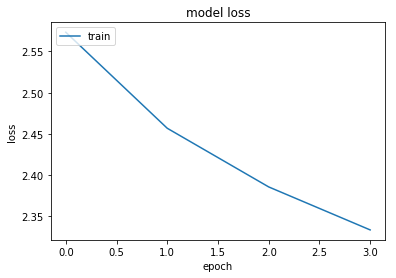

In [95]:
plot_loss(history)

## Predict funtion

In [72]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [73]:
def beam_search_predictions(image, beam_index = 3):
    start = [word2idx["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = encoding_test[image[len(images):]]
            preds = final_model.predict([np.array([e]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

Normal Max search: How long has he been skiing
Beam Search, k=3: What mountain is this
Beam Search, k=5: Where is he skiing
Beam Search, k=7: What mountain is this


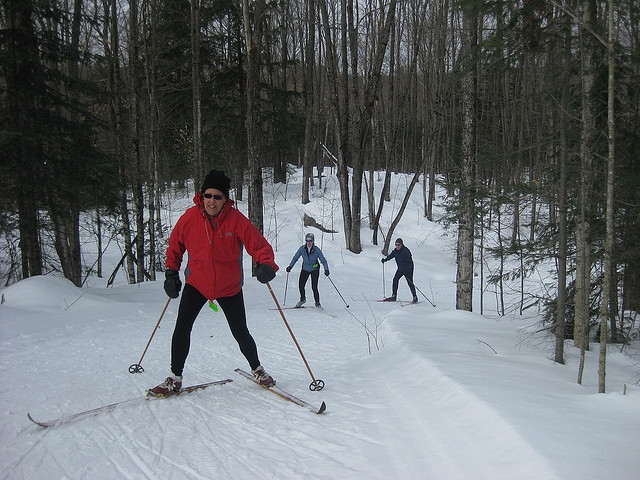

In [75]:

im = 'VQg_dataset/VQG_Dataset/400094.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: What breed of dog is that
Beam Search, k=3: What is the dog's name
Beam Search, k=5: What is the dog's name
Beam Search, k=7: What is the dog's name


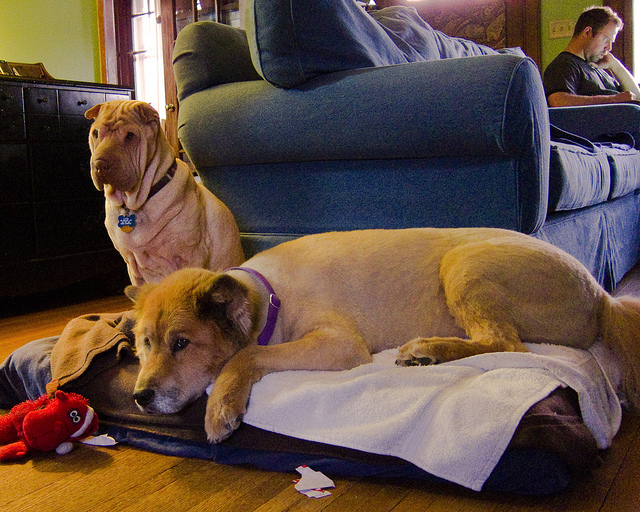

In [76]:

im = 'VQg_dataset/VQG_Dataset/465225.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: What teams are playing
Beam Search, k=3: Who won the game
Beam Search, k=5: Who won the game
Beam Search, k=7: Who won the game


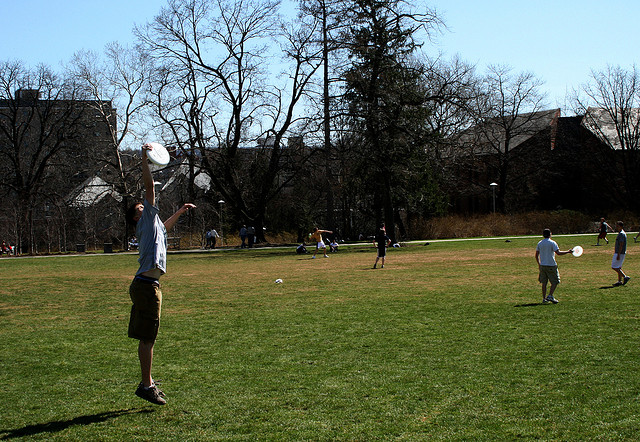

In [83]:

im = 'VQg_dataset/VQG_Dataset/300326.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: What kind of flowers are those
Beam Search, k=3: What kind of flowers are in the vase
Beam Search, k=5: What kind of flowers are in the vase
Beam Search, k=7: What kind of flowers are they


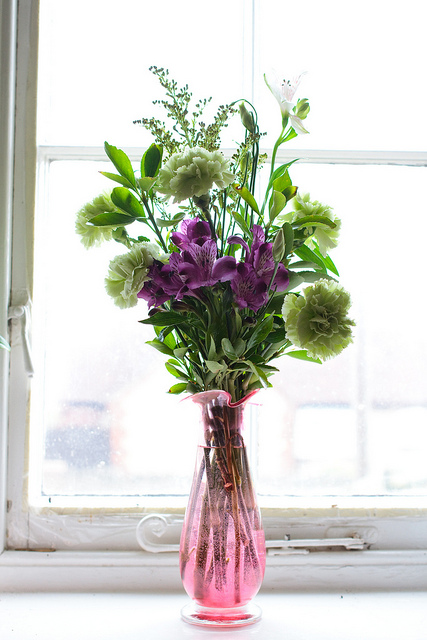

In [78]:

im = 'VQg_dataset/VQG_Dataset/221557.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: What city is this street in
Beam Search, k=3: Where is this
Beam Search, k=5: Where is this located
Beam Search, k=7: Where is this located


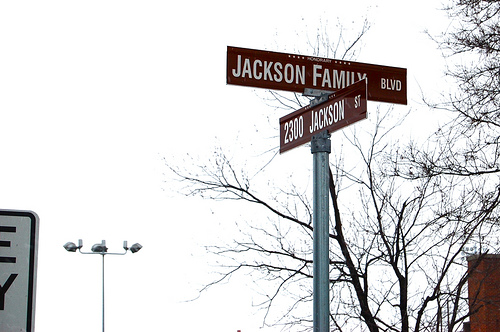

In [88]:
im = 'VQg_dataset/VQG_Dataset/279350.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: What is the man in the bike riding on
Beam Search, k=3: How fast can this bike go
Beam Search, k=5: What kind of bike is that
Beam Search, k=7: What kind of bike is that


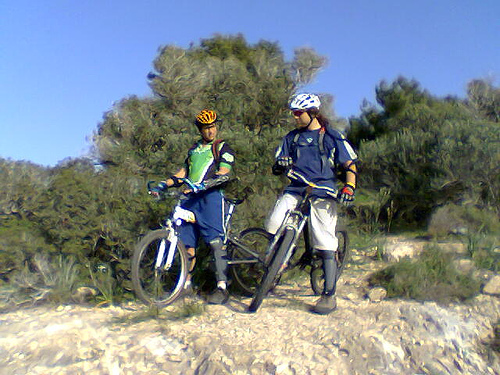

In [81]:
im = 'VQg_dataset/VQG_Dataset/42493.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: Is this a hotel room
Beam Search, k=3: Is this a hotel room
Beam Search, k=5: Whose house is this
Beam Search, k=7: Whose house is this


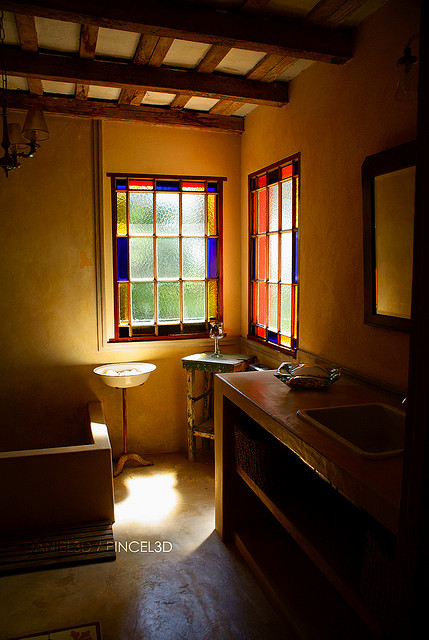

In [91]:
im = 'VQg_dataset/VQG_Dataset/556356.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: What is the cat looking at
Beam Search, k=3: What is the cat looking at
Beam Search, k=5: What is the cats name
Beam Search, k=7: What is the cats name


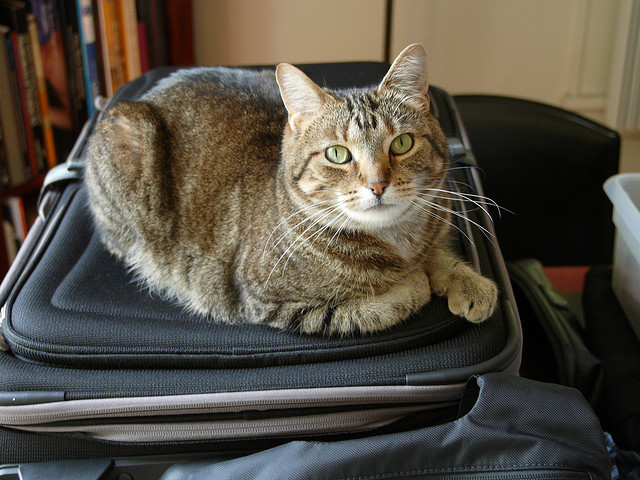

In [92]:
im = 'VQg_dataset/VQG_Dataset/308549.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)